# Project: Adversarial BayesFlow

# Experiment 3b: Diffusion Model (Unbounded Priors)

In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy
import tensorflow as tf
#import tensorflow_probability as tfp
from scipy import stats
from tqdm import tqdm
import matplotlib.patches as mpatches
import matplotlib.colors

import pickle

from numba import njit

sys.path.append(os.path.abspath(os.path.join('../BayesFlow')))

from bayesflow.trainers import ParameterEstimationTrainer
from bayesflow.networks import InvertibleNetwork, InvariantNetwork
from bayesflow.amortizers import SingleModelAmortizer
from bayesflow.models import GenerativeModel
from bayesflow.diagnostics import plot_sbc

from abf_functions import *

RERUN_GRID_EXPERIMENT = True

In [2]:
plt.rcParams.update({
    "axes.labelsize" : 20,
    "xtick.labelsize" : 16,
    "ytick.labelsize" : 16,
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times"],
})

FILEFORMAT = 'pdf'
DPI = 300

In [3]:
def prior(batch_size):
    """
    Samples from the prior 'batch_size' times.
    ----------

    Arguments:
    batch_size : int -- the number of samples to draw from the prior
    ----------

    Output:
    theta : np.ndarray of shape (batch_size, theta_dim) -- the samples batch of parameters
    """

    # Prior ranges for the simulator
    
    p_samples = np.random.gamma(5, 0.5, size=(batch_size, 5))
    return p_samples.astype(np.float32)


@njit
def diffusion_trial(v, a, ndt, zr, dt, max_steps):
    """Simulates a trial from the diffusion model."""

    n_steps = 0.
    x = a * zr

    # Simulate a single DM path
    while (x > 0 and x < a and n_steps < max_steps):

        # DDM equation
        x += v*dt + np.sqrt(dt) * np.random.normal()

        # Increment step
        n_steps += 1.0

    rt = n_steps * dt
    return rt + ndt if x > 0. else -rt - ndt

@njit
def diffusion_condition(n_trials, v, a, ndt, zr=0.5, dt=0.005, max_steps=1e4):
    """Simulates a diffusion process over an entire condition."""

    x = np.empty(n_trials)
    for i in range(n_trials):
        x[i] = diffusion_trial(v, a, ndt, zr, dt, max_steps)
    return x


@njit
def diffusion_2_conds(params, n_trials, dt=0.005, max_steps=1e4):
    """
    Simulates a diffusion process for 2 conditions with 5 parameters (v1, v2, a1, a2, ndt).
    """

    n_trials_c1 = n_trials[0]
    n_trials_c2 = n_trials[1]

    v1, v2, a1, a2, ndt = params
    rt_c1 = diffusion_condition(n_trials_c1, v1, a1, ndt,  dt=dt, max_steps=max_steps)
    rt_c2 = diffusion_condition(n_trials_c2, v2, a2, ndt, dt=dt, max_steps=max_steps)
    rts = np.concatenate((rt_c1, rt_c2))
    return rts


def batch_simulator(prior_samples, n_obs, dt=0.005, s=1.0, max_iter=1e4):
    """
    Simulate multiple diffusion_model_datasets.
    """

    n_sim = prior_samples.shape[0]
    sim_data = np.empty((n_sim, n_obs), dtype=np.float32)

    n1 = n_obs//2
    n2 = n_obs - n1

    # Simulate diffusion data
    for i in range(n_sim):
        sim_data[i] = diffusion_2_conds(prior_samples[i], (n1, n2))

    # Create condition labels
    cond_arr = np.stack(n_sim * [np.concatenate((np.zeros(n1), np.ones(n2)))] )
    sim_data = np.stack((sim_data, cond_arr), axis=-1)

    return sim_data

In [4]:
D = 5  # 5 parameters in total

summary_meta = {
    'n_dense_s1': 2,
    'n_dense_s2': 2,
    'n_dense_s3': 2,
    'n_equiv':    2,
    'dense_s1_args': {'activation': 'relu', 'units': 128},
    'dense_s2_args': {'activation': 'relu', 'units': 128},
    'dense_s3_args': {'activation': 'relu', 'units': 128},
}

class BottleneckSummaryNet(tf.keras.Model):
    def __init__(self, inv_meta={}, n_out=10, activation_out=None):
        super(BottleneckSummaryNet, self).__init__()

        self.invariant_net = InvariantNetwork(inv_meta)
        self.out_layer = tf.keras.layers.Dense(n_out, activation=activation_out)
    
    def __call__(self, x):
        out_inv = self.invariant_net(x)
        out = self.out_layer(out_inv)
        return out


summary_net = BottleneckSummaryNet(inv_meta=summary_meta, 
                                   n_out=D*2,  # twice the required
                                   activation_out=None  # linear
                                  )


inference_meta = {
    'n_coupling_layers': 4,
    's_args': {
        'units': [128, 128],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    't_args': {
        'units': [128, 128],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    'n_params': 5,
    'alpha': 1.9,
    'permute': True
}


inference_net = InvertibleNetwork(inference_meta)
amortizer = SingleModelAmortizer(inference_net, summary_net)

generative_model = GenerativeModel(prior, batch_simulator)

trainer = ParameterEstimationTrainer(amortizer,
                      generative_model,
                      loss=mmd_kl_loss,
                      learning_rate=0.0007,
                      checkpoint_path='export_ckpt/mmd/ddm_unbounded',
                      max_to_keep = 2
                     )

2021-12-09 18:33:41.872992: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-09 18:33:41.873220: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Networks loaded from export_ckpt/mmd/ddm_unbounded/ckpt-75


In [5]:
#losses = trainer.train_online(epochs=75, iterations_per_epoch=1000, batch_size=64, n_obs=100)

## Validate Performance

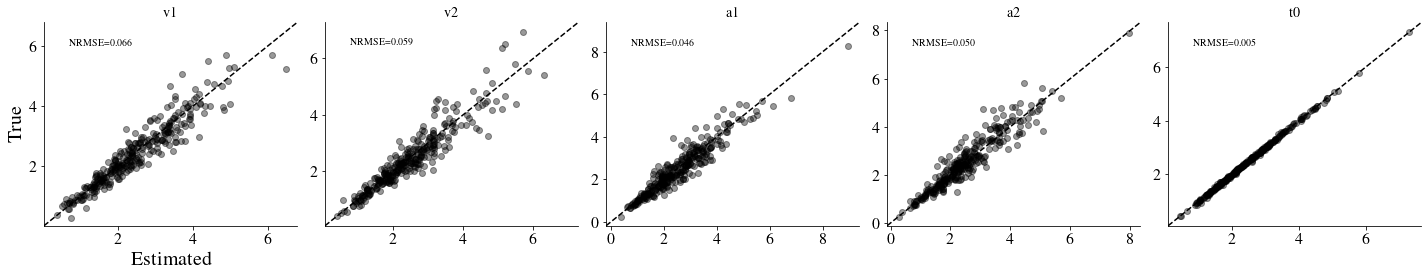

In [6]:
# Validate (quick and dirty)
p, x = trainer._forward_inference(300, 100)
param_samples = amortizer.sample(x, n_samples=2000)
param_means = param_samples.mean(axis=0)
true_vs_estimated(p, param_means, ['v1', 'v2', 'a1', 'a2', 't0'], figsize=(20,4))

In [7]:
p_sbc, x_sbc = trainer._forward_inference(5000, 100)

In [8]:
param_samples_sbc = tf.concat([amortizer.sample(x_, n_samples=250) 
                               for x_ in tf.split(x_sbc, 20, axis=0)], axis=1) 

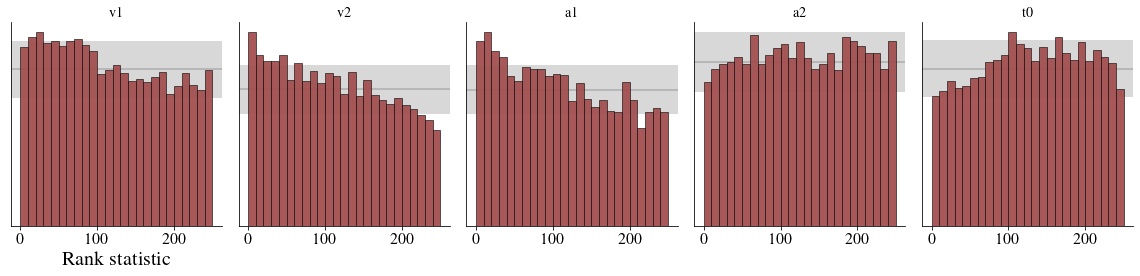

In [9]:
f = plot_sbc(param_samples_sbc, p_sbc, ['v1', 'v2', 'a1', 'a2', 't0'], figsize=(16, 4), show=False)

In [10]:
def contamination_dist_fast_guesses(percentiles, n):    
    return np.random.uniform(0.1, percentiles[10], n)

def contamination_dist_slow_responses(percentiles, n):   
    return np.random.uniform(percentiles[75], 10.0, n)

def contamination_dist_fast_and_slow(percentiles, n):
    n1 = int(n/2)
    n2 = n-n1
    fast = contamination_dist_fast_guesses(percentiles, n1)
    slow = contamination_dist_slow_responses(percentiles, n2)
    return np.concatenate((fast, slow))

def contaminate(x, contamination_dist, c=0.1):
    """
    Contaminate the random variate vector x with contaminants according to fraction c \in [0, 1]
    """
    #x_contamination = x.copy()
    
    if not x.size > 0:
        return x

    
    n = x.shape[0]
    n_contamination = int(n * c)
    contamination_idx = np.random.default_rng().choice(n, size=n_contamination, replace=False)
    
    percentiles = np.percentile(x, range(101))
    
    sampled_contamination = contamination_dist(percentiles, n_contamination)
    assert sampled_contamination.shape[0] == n_contamination
    
    
    x[contamination_idx] = sampled_contamination
    return x

def split_posneg_contaminate(x, contamination_dist, c):
    pos_idx = np.where(x>=0)
    neg_idx = np.where(x<0)
    
    x[pos_idx] = contaminate(x[pos_idx], contamination_dist=contamination_dist, c=c)
    x[neg_idx] = contaminate(x[neg_idx], contamination_dist=contamination_dist, c=c)
    return x

def contaminate_dm_data(x, contamination_dist, c=0.1):
    x_copy = x.copy()
    n_sim, n_obs, data_dim = x_copy.shape
    for bi in range(n_sim):
        x_copy[bi, :(n_obs//2), 0] = split_posneg_contaminate(x_copy[bi, :(n_obs//2), 0], contamination_dist, c=c)
        x_copy[bi, (n_obs//2):, 0] = split_posneg_contaminate(x_copy[bi, (n_obs//2):, 0], contamination_dist, c=c)
    return x_copy

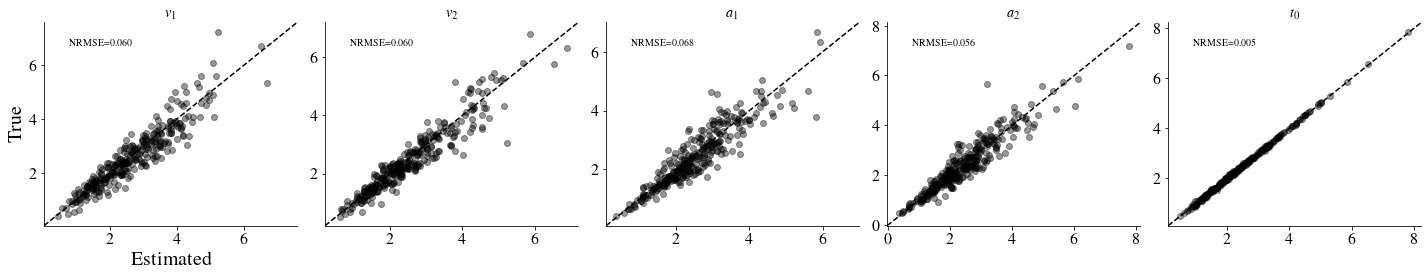

In [11]:
# Baseline
theta, x = trainer._forward_inference(300, 100)

param_samples = trainer.network.sample(x, n_samples=2000)
param_means = param_samples.mean(axis=0)

true_vs_estimated(theta, param_means, [r'$v_1$', r'$v_2$', r'$a_1$', r'$a_2$', r'$t_0$'], figsize=(20,4),
                 filename=f'plots/abf_ddm_unbounded_true_est_baseline.{FILEFORMAT}')


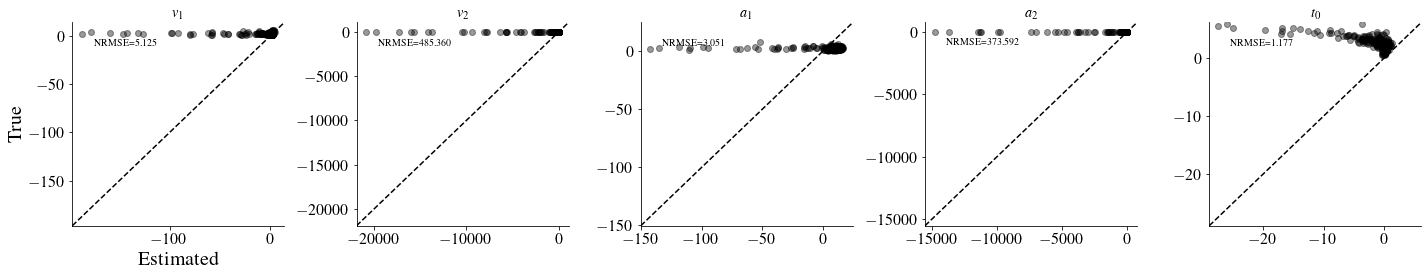

In [12]:
# Fast guesses
theta, x = trainer._forward_inference(300, 100)
x_o = contaminate_dm_data(x, contamination_dist=contamination_dist_fast_guesses, c=0.1)

param_samples = trainer.network.sample(x_o, n_samples=2000)
param_means = param_samples.mean(axis=0)

true_vs_estimated(theta, param_means, [r'$v_1$', r'$v_2$', r'$a_1$', r'$a_2$', r'$t_0$'], figsize=(20,4),
                 filename=f'plots/abf_ddm_unbounded_true_est_fast.{FILEFORMAT}')

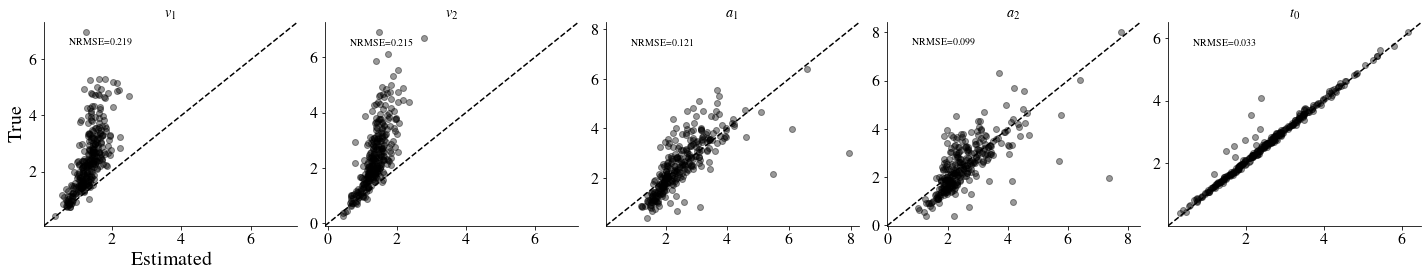

In [13]:
# Slow responses
theta, x = trainer._forward_inference(300, 100)
x_o = contaminate_dm_data(x, contamination_dist=contamination_dist_slow_responses, c=0.1)

param_samples = trainer.network.sample(x_o, n_samples=2000)
param_means = param_samples.mean(axis=0)

true_vs_estimated(theta, param_means, [r'$v_1$', r'$v_2$', r'$a_1$', r'$a_2$', r'$t_0$'], figsize=(20,4),
                  filename=f'plots/abf_ddm_unbounded_true_est_slow.{FILEFORMAT}')

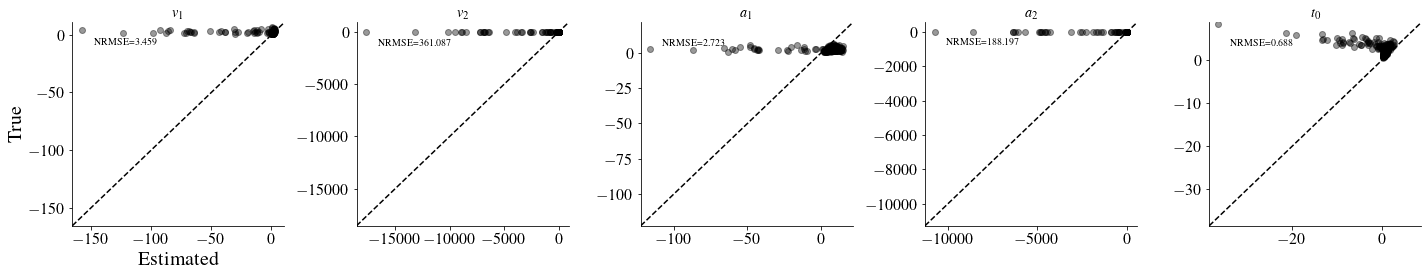

In [14]:
# Fast guesses and slow responses
theta, x = trainer._forward_inference(300, 100)
x_o = contaminate_dm_data(x, contamination_dist=contamination_dist_fast_and_slow, c=0.1)

param_samples = trainer.network.sample(x_o, n_samples=2000)
param_means = param_samples.mean(axis=0)

true_vs_estimated(theta, param_means, [r'$v_1$', r'$v_2$', r'$a_1$', r'$a_2$', r'$t_0$'], figsize=(20,4),
                 filename=f'plots/abf_ddm_unbounded_true_est_fast_slow.{FILEFORMAT}')

In [15]:
colors = sns.color_palette("viridis", n_colors=4)

color_codes = {
    "No MMS" : colors[0],
    "fast" : colors[1],
    "slow" : colors[2],
    "fast+slow" : colors[3]
}

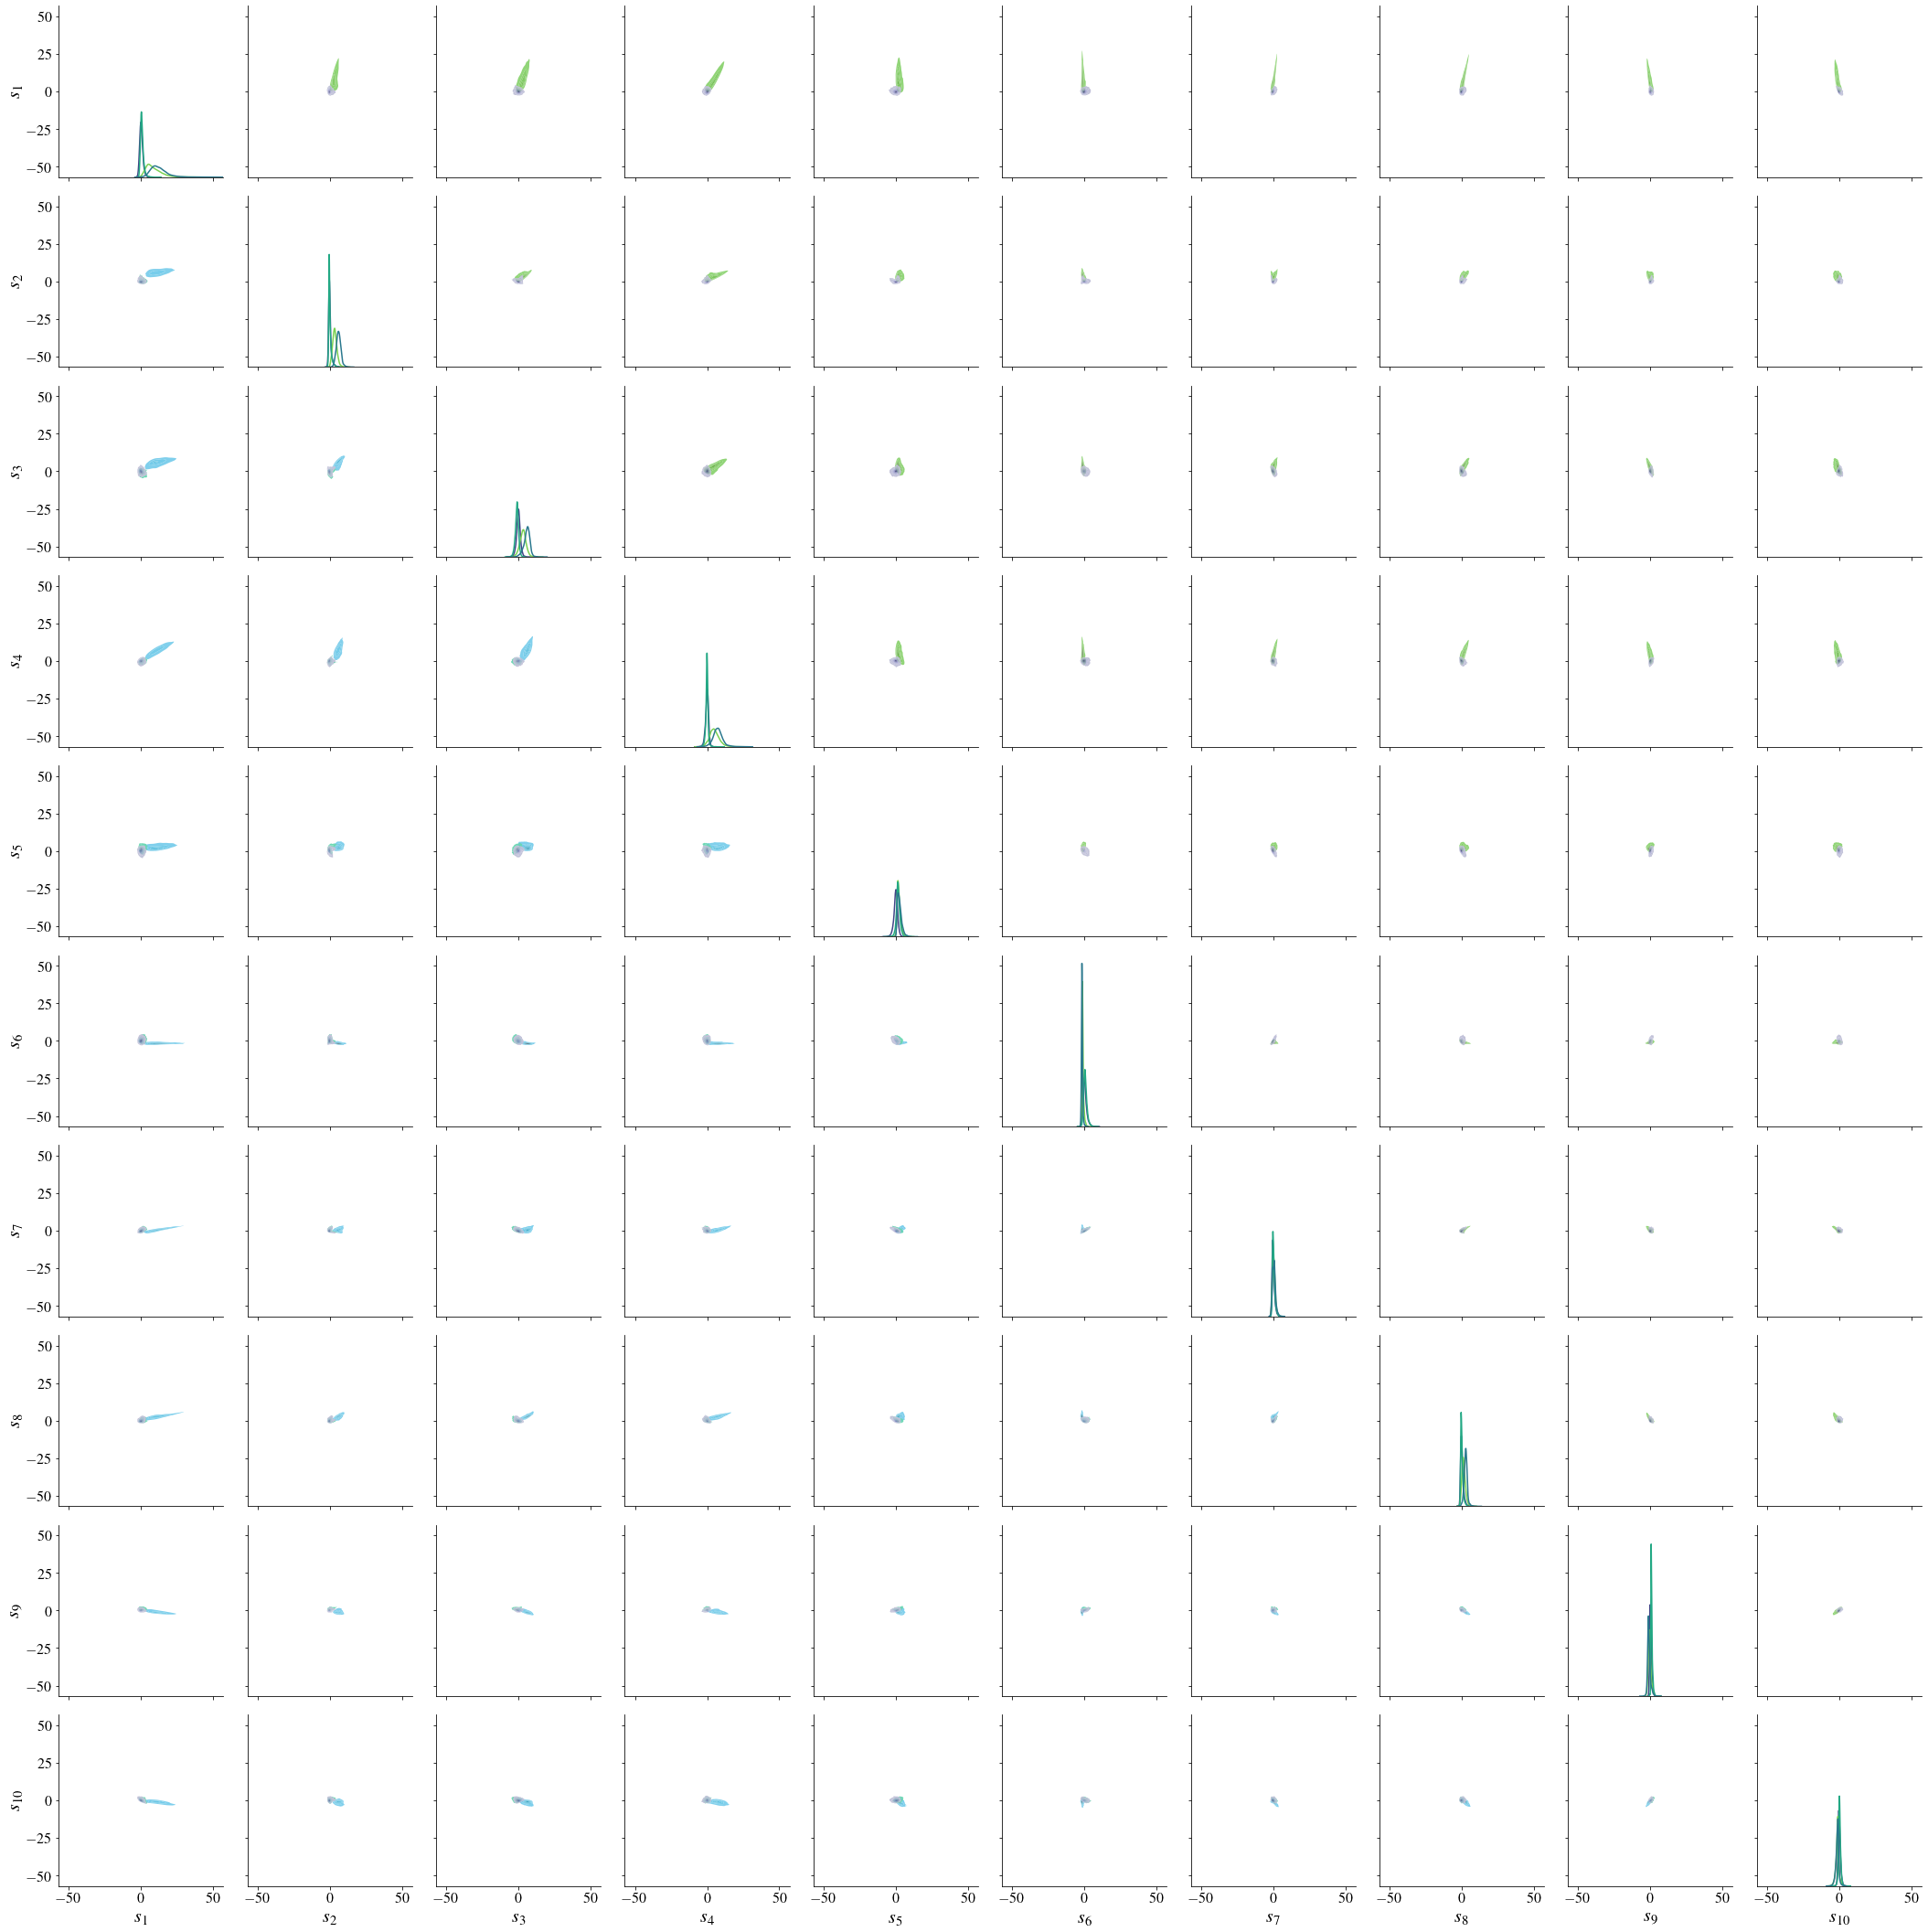

In [16]:
n_sim = 10000


# Pairplot of summary network outputs
theta, x_uncontaminated = trainer._forward_inference(n_sim, 100)

x_o_fast = contaminate_dm_data(x_uncontaminated, contamination_dist=contamination_dist_fast_guesses, c=0.1)
x_o_slow = contaminate_dm_data(x_uncontaminated, contamination_dist=contamination_dist_slow_responses, c=0.1)
x_o_fast_slow = contaminate_dm_data(x_uncontaminated, contamination_dist=contamination_dist_fast_and_slow, c=0.1)

X = [x_o_fast, x_o_slow, x_o_fast_slow, x_uncontaminated]
TASK_NAMES = ['fast', 'slow', 'fast+slow', 'No MMS']

DF = (pd.DataFrame(np.array(trainer.network.summary_net(x)), 
                     columns=[r'$s_{%i}$'%i for i in range(1, 11)]) for x in X)

df = pd.concat(DF,
              keys=TASK_NAMES,
              names=['MMS', None]
              ).reset_index(level=0).reset_index(drop=True)

def plot_subset(x, y, hue, mask, **kws):
    sns.kdeplot(x=x[mask], y=y[mask], hue=hue[mask], fill=True, levels=10, antialiased=True, **kws)

g = sns.PairGrid(df, hue="MMS", height=3, palette=[color_codes[task_name] for task_name in TASK_NAMES] )

g.map_diag(sns.kdeplot)

g.map_lower(plot_subset, mask= 
            (
                (df["MMS"] == 'fast') |
                (df["MMS"] == 'slow') |
                (df["MMS"] == 'No MMS')
           )
           )


g.map_upper(plot_subset, mask= 
            (
                (df["MMS"] == 'fast+slow') |
                (df["MMS"] == 'No MMS')
           )
           )




absmax = np.ceil(np.abs(df.iloc[:, 1:].values).max())
ticks = np.arange(-100, 100, 5)
ticks = ticks[(ticks>-absmax) & (ticks<absmax)]

for ax in g.axes.flatten():
    ax.set_xlim(-absmax, absmax)
    ax.set_ylim(-absmax, absmax)
    
    #ax.set_xticks(ticks)
    #ax.set_yticks(ticks)
    

plt.savefig(f"plots/abf_ddm_unbounded_pairplot.{FILEFORMAT}", bbox_inches="tight", dpi=DPI)

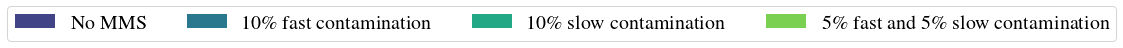

In [17]:
plt.figure(figsize=(0.1,0.1))
plt.gca().set_axis_off()
handles = [mpatches.Patch(facecolor=color_codes["No MMS"], label=r"No MMS"),
           mpatches.Patch(facecolor=color_codes["fast"], label=r"$10\%$ fast contamination"),
           mpatches.Patch(facecolor=color_codes["slow"], label=r"$10\%$ slow contamination"),
           mpatches.Patch(facecolor=color_codes["fast+slow"], label=r"$5\%$ fast and $5\%$ slow contamination")
           ]
plt.legend(handles=handles, loc="center", ncol=4, title="" ,fontsize=20, labelspacing=2)
plt.savefig(f"plots/abf_ddm_unbounded_pairplot_legend.{FILEFORMAT}", bbox_inches="tight", dpi=DPI)

# MMS paper: contour plot

In [18]:
def contamination_dist_fast_guesses(percentiles, n):    
    return np.random.uniform(0.1, percentiles[10], n)

def contamination_dist_slow_responses(percentiles, n):
    return np.random.uniform(percentiles[75], 10.0, n)

def contamination_dist_fast_and_slow(percentiles, n1, n2):
    fast = contamination_dist_fast_guesses(percentiles, n1)
    slow = contamination_dist_slow_responses(percentiles, n2)
    return np.concatenate((fast, slow))

def contaminate_grid(x, c_slow, c_fast):
    """
    Contaminate the random variate vector x with contaminants according to fraction c \in [0, 1]
    """

    if not x.size > 0:
        return x

    n = x.shape[0]
    c = c_slow + c_fast
    n_contamination = int(n * c)
    contamination_idx = np.random.default_rng().choice(n, size=n_contamination, replace=False)
    
    percentiles = np.percentile(x, range(101))
    
    n_slow = int(n * c_slow)
    n_fast = n_contamination - n_slow
    sampled_contamination = contamination_dist_fast_and_slow(percentiles, n_slow, n_fast)
    assert sampled_contamination.shape[0] == n_contamination
    
    
    x[contamination_idx] = sampled_contamination
    return x

def split_posneg_contaminate(x, c_slow, c_fast):
    pos_idx = np.where(x>=0)
    neg_idx = np.where(x<0)
    
    x[pos_idx] = contaminate_grid(x[pos_idx], c_slow, c_fast)
    x[neg_idx] = contaminate_grid(x[neg_idx], c_slow, c_fast)

    
    return x


def contaminate_dm_data_grid(x, c_slow, c_fast):
    x_copy = x.copy()
    n_sim, n_obs, data_dim = x_copy.shape
    for bi in range(n_sim):
        x_copy[bi, :(n_obs//2), 0] = split_posneg_contaminate(x_copy[bi, :(n_obs//2), 0], c_slow, c_fast)
        x_copy[bi, (n_obs//2):, 0] = split_posneg_contaminate(x_copy[bi, (n_obs//2):, 0], c_slow, c_fast)
    return x_copy

In [ ]:
n_slow = 101
n_fast = 101
slow_list = np.linspace(0.0, 0.1, num = n_slow)
fast_list = np.linspace(0.0, 0.5, num = n_fast)

slow_grid, fast_grid = np.meshgrid(slow_list, fast_list)

if RERUN_GRID_EXPERIMENT:
    _, x = trainer._forward_inference(200, 100)
    z_psi = np.array(trainer.network.summary_net(x))

    MMD = np.zeros((n_fast, n_slow))
    for i in tqdm(range(n_fast)):
        for j in range(n_slow):
            c_slow = slow_grid[i, j]
            c_fast = fast_grid[i, j]
            _, x_o = generative_model(200, 100)

            x_o = contaminate_dm_data_grid(x, c_slow=c_slow, c_fast=c_fast)
            s_o = np.array(trainer.network.summary_net(x_o))

            MMD[i, j] = float(maximum_mean_discrepancy(s_o, z_psi, squared=False))
          
    np.save(f"data/MMD_grid_experiments/MMD_DDM_grid.npy", MMD)

MMD = np.load(f"data/MMD_grid_experiments/MMD_DDM_grid.npy")
plt.figure()
#plt.gca().set_aspect('equal', adjustable='box')

plt.pcolor(slow_grid, fast_grid, MMD, shading="nearest", rasterized=True)
plt.xlabel(r"$\lambda_{\mathrm{slow}}$")
plt.ylabel(r"$\lambda_{\mathrm{fast}}$")
plt.axhline(y=0.0, linestyle="--", color="lightgreen", alpha=.80, linewidth=3)
plt.axvline(x=0.0, linestyle="--", color="lightgreen", alpha=.80, linewidth=3)

cbar = plt.colorbar()
cbar.ax.set_xlabel(r"$\widehat{rMMD}$")

plt.savefig(f"plots/abf_ddm_grid.{FILEFORMAT}", bbox_inches="tight")

## PCA

In [19]:
from sklearn.decomposition import PCA

In [20]:
ddm_columnnames = [r'$v_1$', r'$v_2$', r'$a_1$', r'$a_2$', r'$t_0$']

# Simulate data and compute summary network output s
theta, x = trainer._forward_inference(10000, 100)
s = np.array(trainer.network.summary_net(x))

n_pcs = 10
pca = PCA(n_pcs)
pcs = pca.fit_transform(s)

df_theta = pd.DataFrame(theta, columns=ddm_columnnames)
df_pcs = pd.DataFrame(pcs, columns=[f"PC{j}" for j in range(1, n_pcs+1)])
df = pd.concat([df_theta, df_pcs], axis=1)
r = df.corr().iloc[:5, 5:]

r2 = pd.DataFrame(np.cumsum(pca.explained_variance_ratio_),
                    index=[f"PC{j}" for j in range(1, n_pcs+1)],
                    columns=[r"$\sum R^2$"]).T

#h2 = np.sum(np.array(r)**2, axis=1)
#r[r'$h^2$']=(h2)

r = r.append(r2)


r_styled = r.style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1, 
                           subset=(r.index[:-1], r.columns[:])).set_precision(2)
r_styled

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
$v_1$,-0.06,0.02,-0.64,0.45,-0.29,-0.09,0.06,0.04,0.08,-0.01
$v_2$,0.00,-0.64,-0.27,-0.47,-0.12,-0.06,0.10,0.00,0.08,-0.04
$a_1$,0.10,-0.18,0.52,0.16,-0.65,0.10,0.13,-0.10,0.02,-0.13
$a_2$,0.00,0.63,-0.15,-0.49,-0.28,0.04,0.19,-0.02,0.07,-0.02
$t_0$,0.99,0.02,-0.08,-0.00,0.06,-0.02,-0.02,0.02,-0.02,-0.00
$\sum R^2$,0.31,0.46,0.60,0.73,0.85,0.95,0.99,1.00,1.00,1.00


## BayesFlow vs. Stan

In [21]:
def plot_subset(x, y, hue, mask, **kws):
    sns.kdeplot(x=x[mask], y=y[mask], hue=hue[mask], fill=True, levels=10, antialiased=True, **kws)

In [22]:
colors = sns.color_palette("plasma", 2)

color_codes_approximators = {
    'Stan' : colors[0],
    'BayesFlow' : colors[1]
}
approximator_names = list(color_codes_approximators.keys())

In [23]:
with open("export_stan_posteriors/data_posteriors.pkl", 'rb') as f:
    data_posteriors = pickle.load(f)
with open("export_stan_posteriors/stan_posteriors.pkl", 'rb') as f:
    stan_posteriors = pickle.load(f)
with open("export_stan_posteriors/params.pkl", "rb") as f:
    data_params = pickle.load(f)

In [24]:
def get_posteriors(data_index):
    """
    Utility to extract posteriors from stan and simultaneously sample from BayesFlow.
    """
    
    par_names_tex = [r'$v_1$', r'$v_2$', r'$a_1$', r'$a_2$', r'$t_0$']
    exp_keys = list(stan_posteriors.keys())
    bayesflow_posteriors_dict = {}
    stan_posteriors_dict = {}
    for exp in exp_keys:
        
        # Convert samples from stan to df with nice columns
        df_stan = pd.DataFrame(
            stan_posteriors[exp][data_index],
        )
        df_stan = df_stan.drop('lp__', axis=1)
        df_stan.columns = par_names_tex
        
        # Sample from bayesflow and convert to a data frame
        df_bayesflow = pd.DataFrame(
            amortizer.sample(
                data_posteriors[exp][data_index][np.newaxis], len(df_stan)
            ), 
            columns=par_names_tex
        )
        
        stan_posteriors_dict[exp] = df_stan
        bayesflow_posteriors_dict[exp] = df_bayesflow
    return stan_posteriors_dict, bayesflow_posteriors_dict

def plot_bivariate(df_stan, df_bayesflow, subsample_frac=None, save=False, save_suffix=None):
    """Helper to plot."""
    
    # For speedy testing
    if subsample_frac is not None:
        df_stan = df_stan.sample(frac=subsample_frac, replace=False)
        df_bayesflow = df_bayesflow.sample(frac=subsample_frac, replace=False)
    
    # Stack dataframes
    df = pd.concat(
        (df_stan, df_bayesflow),
    ).reset_index(drop=True)
    df['Method'] = ['Stan'] * len(df_stan) + ['BayesFlow'] * len(df_bayesflow)
    
    # Plot
    g = sns.PairGrid(df, height=3, hue="Method", 
                     palette=[color_codes_approximators[approximator_name] 
                              for approximator_name in approximator_names])
    g.map_diag(sns.kdeplot, linewidth=3)
    g.map_lower(sns.kdeplot, fill=True, levels=10, antialiased=True)
    g.map_upper(sns.kdeplot, fill=True, levels=10, antialiased=True)
    
    if save:
        plt.savefig(f"plots/abf_ddm_unbounded_pairplot_stan_bf_{save_suffix}.{FILEFORMAT}", bbox_inches="tight", dpi=DPI)
    
    plt.figure(figsize=(0.1,0.1))
    plt.gca().set_axis_off()
    handles = [mpatches.Patch(facecolor=color_codes_approximators["Stan"], label=r"Stan"),
               mpatches.Patch(facecolor=color_codes_approximators["BayesFlow"], label=r"BayesFlow")
               ]
    plt.legend(handles=handles, loc="center", ncol=4, title="" ,fontsize=20, labelspacing=2)
    if save:
        plt.savefig(f"plots/abf_ddm_unbounded_pairplot_stan_bf_legend_{save_suffix}.{FILEFORMAT}", bbox_inches="tight", dpi=DPI)

In [25]:
stan_p = []
bayesflow_p = []
for i in range(len(data_posteriors['clean'])):
    s, b = get_posteriors(i)
    stan_p.append(s['clean'])
    bayesflow_p.append(b['clean'])
stan_p = np.array(stan_p)
bayesflow_p = np.array(bayesflow_p)

In [26]:
models = ["clean", "fast", "slow", "fast_slow"]

MMDs = {
"clean": [],
"fast" : [],
"slow" : [],
"fast_slow": []
}

for model in models:
    print(f"Processing model: {model}")
    posteriors = data_posteriors[model]
    for i in tqdm(range(len(posteriors))):
        stan, bf = get_posteriors(i)
        MMD = maximum_mean_discrepancy(np.array(stan[model], dtype=np.float32), np.array(bf[model], dtype=np.float32), squared=False)
        MMDs[model].append(MMD)

  0%|                                                                                                                                                                                                                                                            | 0/100 [00:00<?, ?it/s]

Processing model: clean


  0%|                                                                                                                                               | 0/100 [00:00<?, ?it/s]

Processing model: fast


  0%|                                                                                                                                               | 0/100 [00:00<?, ?it/s]

Processing model: slow


  0%|                                                                                                                                               | 0/100 [00:00<?, ?it/s]

Processing model: fast_slow


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [08:16<00:00,  4.96s/it]


clean: mean=0.27, SD=0.10
fast: mean=2.62, SD=0.56
slow: mean=0.57, SD=0.21
fast_slow: mean=1.91, SD=0.67


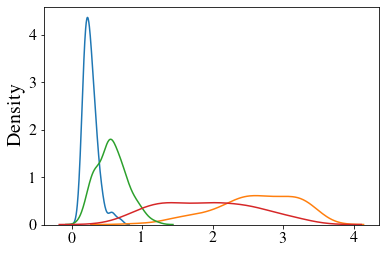

In [27]:
for model in models:
    MMD = np.array(MMDs[model])
    print(f"{model}: mean={np.mean(MMD):.2f}, SD={np.std(MMD):.2f}")
    sns.kdeplot(MMD)

In [ ]:
models = ["clean", "fast", "slow", "fast_slow"]

In [ ]:
bf_means = bayesflow_p.mean(1)
stan_means = stan_p.mean(1)

In [ ]:
true_vs_estimated(data_params, bf_means, ['v1', 'v2', 'a1', 'a2', 't0'], figsize=(20,4))

In [ ]:
true_vs_estimated(data_params, stan_means, ['v1', 'v2', 'a1', 'a2', 't0'], figsize=(20,4))

In [28]:
indices = [2, 2]
models = ['clean', 'slow']

for index, model in zip(indices, models):
    test_stan, test_bf = get_posteriors(index)
    posterior_MMD = maximum_mean_discrepancy(np.array(test_stan[model], dtype=np.float32), np.array(test_bf[model], dtype=np.float32), squared=False)
    
    x_obs = data_posteriors[model][index][np.newaxis]
    s_obs = trainer.network.summary_net(x_obs)
    _, x_star = trainer._forward_inference(1, 100)
    z_x = trainer.network.summary_net(x_star)
    summary_MMD = maximum_mean_discrepancy(z_x, s_obs, squared=False)
    
    print(f"{model}, index {index}: Posterior MMD={posterior_MMD:.3f}, summary MMD={summary_MMD:.3f}")


clean, index 2: Posterior MMD=0.159, summary MMD=4.380
slow, index 2: Posterior MMD=0.921, summary MMD=4.439


In [ ]:
indices = [2, 2]
models = ["clean", "slow"]

for index, model in zip(indices, models):
    test_stan, test_bf = get_posteriors(index)
    plot_bivariate(test_stan[model], test_bf[model], subsample_frac=None, save=True, save_suffix=model)
    #plt.savefig(f"plots/abf_ddm_pairplot_stan_bf_{model}.{FILEFORMAT}", bbox_inches="tight", dpi=DPI)

MMD test

In [ ]:
n_H0_samples = 1000
N_star = 500

_, x_star_fixed = trainer._forward_inference(N_star, 100)
s_star_fixed = trainer.network.summary_net(x_star)

MMD_H0 = np.empty(n_H0_samples)
for i in tqdm(range(n_H0_samples)):
    _, x_star_N1 = trainer._forward_inference(1, 100)
    s_star_N1 = trainer.network.summary_net(x_star_N1)
    MMD_H0[i] = maximum_mean_discrepancy(s_star_fixed, s_star_N1, squared=False)

    x_obs_uncontaminated = data_posteriors["clean"][2][np.newaxis]
    s_obs_uncontaminated = trainer.network.summary_net(x_obs_uncontaminated)
    MMS_uncontaminated = maximum_mean_discrepancy(s_star_fixed, s_obs_uncontaminated, squared=False)
    
    x_obs_contaminated = data_posteriors["slow"][2][np.newaxis]
    s_obs_contaminated = trainer.network.summary_net(x_obs_contaminated)
    MMS_contaminated = maximum_mean_discrepancy(s_star_fixed, s_obs_contaminated, squared=False)

In [ ]:
def draw_vline_to_kde(x, kde_object, color, **kwargs):
    kde_x, kde_y = kde_object.lines[0].get_data()
    idx = np.argmin(np.abs(kde_x - x))
    plt.plot([x, x], [0, kde_y[idx]], color=color, linewidth=4, **kwargs)

plt.figure(figsize=(8, 4))
alpha = 0.05
H0_color = "#287D8EFF"
uncontaminated_color = "#55C667FF"
contaminated_color = "#453781FF"
alpha_color = "#481567FF"

kde = sns.kdeplot(MMD_H0, fill=False, linewidth=0, cut=0)
sns.kdeplot(MMD_H0, fill=True, alpha=.12, color = H0_color, cut=0)

draw_vline_to_kde(MMS_uncontaminated, kde, uncontaminated_color, label=r"Uncontaminated", linestyle="dashed")
draw_vline_to_kde(MMS_contaminated, kde, contaminated_color, label=r"Slow contamination", linestyle="dotted")


MMD_critical = np.quantile(MMD_H0, 1-alpha)
draw_vline_to_kde(MMD_critical, kde, alpha_color, linestyle="dashed", label=r"Critical value")

sns.kdeplot(MMD_H0, fill=False, linewidth=3, color = H0_color, label=r"$H_0$", cut=0)


plt.xlabel(r"$\widehat{\mathrm{rMMD}}$")
plt.ylabel("")
plt.yticks([])

plt.legend(fontsize=20)
sns.despine()

In [ ]:
n_samples = 1000

MMD_H0 = np.empty(n_samples)
MMD_contaminated = np.empty(n_samples)
MMD_uncontaminated = np.empty(n_samples)

for i in tqdm(range(n_samples)):
    _, x_star_H0 = trainer._forward_inference(1, 100)
    s_star_H0 = trainer.network.summary_net(x_star)
    _, x_star = trainer._forward_inference(1, 100)
    s_star = trainer.network.summary_net(x_star)
    MMD_H0[i] = maximum_mean_discrepancy(s_star_H0, s_star, squared=False)

for i in tqdm(range(n_samples)):
    x_obs_uncontaminated = data_posteriors["clean"][2][np.newaxis]
    s_obs_uncontaminated = trainer.network.summary_net(x_obs_uncontaminated)
    _, x_star = trainer._forward_inference(1, 100)
    s_star = trainer.network.summary_net(x_star)
    MMD_contaminated[i] = maximum_mean_discrepancy(s_star, s_obs_uncontaminated, squared=False)
    
for i in tqdm(range(n_samples)):
    x_obs_contaminated = data_posteriors["slow"][2][np.newaxis]
    s_obs_contaminated = trainer.network.summary_net(x_obs_contaminated)
    _, x_star = trainer._forward_inference(1, 100)
    s_star = trainer.network.summary_net(x_star)
    MMD_uncontaminated[i] = maximum_mean_discrepancy(s_star, s_obs_contaminated, squared=False)

In [ ]:
def draw_vline_to_kde(x, kde_object, color, **kwargs):
    kde_x, kde_y = kde_object.lines[0].get_data()
    idx = np.argmin(np.abs(kde_x - x))
    plt.plot([x, x], [0, kde_y[idx]], color=color, linewidth=4, **kwargs)

plt.figure(figsize=(8, 4))
alpha = 0.05
H0_color = "#287D8EFF"
uncontaminated_color = "#55C667FF"
contaminated_color = "#453781FF"
alpha_color = "#481567FF"

sns.kdeplot(MMD_H0, fill=False, alpha=.80, linewidth=3, color = H0_color, cut=0, label=r"$H_0$")
sns.kdeplot(MMD_contaminated, fill=False, alpha=.80, linewidth=3, color = contaminated_color, cut=0, label=r"contaminated")
sns.kdeplot(MMD_uncontaminated, fill=False, alpha=.80, linewidth=3, color = uncontaminated_color, cut=0, label=r"uncontaminated")


plt.xlabel(r"$\widehat{\mathrm{rMMD}}$")
plt.ylabel("")
plt.yticks([])

plt.legend(fontsize=20)
sns.despine()